In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Analysis - Data Preprocessing

In [119]:
# Load the data

# ML1M DATA
ml1m_movies = pd.read_csv('../datasets/ml1m/movies.dat', sep='::', header=None, engine='python', encoding='latin1', names=['product_id', 'title', 'genres'])
ml1m_ratings = pd.read_csv('../datasets/ml1m/ratings.dat', sep='::', header=None, engine='python', encoding='latin1', names=['user_id', 'product_id', 'rating', 'timestamp'])
ml1m_users = pd.read_csv('../datasets/ml1m/users.dat', sep='::', header=None, engine='python', encoding='latin1', names=['user_id', 'gender', 'age', 'occupation', 'zip'])

# LASTFM DATA
lastfm_tracks = pd.read_csv('../datasets/lastfm/tracks.txt', sep=',', engine='python', encoding='latin1', names=['product_id', 'track_name', 'artist_id'])
lastfm_ratings = pd.read_csv('../datasets/lastfm/ratings.dat', sep=',', engine='python', encoding='latin1', names=['user_id', 'artist_id', 'album_id', 'product_id', 'timestamp'])
lastfm_users = pd.read_csv('../datasets/lastfm/users.dat', sep=',', engine='python', encoding='latin1')

### User-Product Information
#### Values According to the paper

In [120]:
# ML1M
ml1m_user_paper = 6040
ml1m_prduct_paper = 3226
ml1m_interactions_paper = 1000209

# LASTFM
lastfm_user_paper = 15773
lastfm_product_paper = 47981
lastfm_interactions_paper = 3955598

In [121]:
print('\t\t| ML1M\t   | LASTFM')
print('-----------------------------------------')
print('Users\t\t| {}\t   | {}'.format(ml1m_user_paper, lastfm_user_paper))
print('Products\t| {}\t   | {}'.format(ml1m_prduct_paper, lastfm_product_paper))
print('Interactions\t| {}  | {}'.format(ml1m_interactions_paper, lastfm_interactions_paper))

		| ML1M	   | LASTFM
-----------------------------------------
Users		| 6040	   | 15773
Products	| 3226	   | 47981
Interactions	| 1000209  | 3955598


#### Before preprocessing

In [122]:
# ML1M
# User count
ml1m_user_count = ml1m_users['user_id'].nunique()

# Movie/Product count
ml1m_movie_count = ml1m_movies['product_id'].nunique()

# Interaction count
ml1m_interaction_count = ml1m_ratings.shape[0]

In [123]:
# LASTFM
# User count
lastfm_user_count = lastfm_users['user_id'].nunique()

# Track/Product count
lastfm_track_count = lastfm_tracks['product_id'].nunique()

# Interaction count
lastfm_interaction_count = lastfm_ratings.shape[0]

In [124]:
print('\t\t| ML1M\t  | LASTFM')
print('-----------------------------------------')
print('Users\t\t| {}\t  | {}'.format(ml1m_user_count, lastfm_user_count))
print('Products\t| {}\t  | {}'.format(ml1m_movie_count, lastfm_track_count))
print('Interactions\t| {} | {}'.format(ml1m_interaction_count, lastfm_interaction_count))

		| ML1M	  | LASTFM
-----------------------------------------
Users		| 6040	  | 15773
Products	| 3883	  | 47982
Interactions	| 1000161 | 21946833


#### After preprocessing

In [125]:
def preprocessing_input(users, products, interactions):

    users = preprocess_users(users)

    (interactions_final, users_final, products_final) = preprocess_interactions(interactions, users, products)

    return (interactions_final, users_final, products_final)

def preprocess_interactions(interactions, users_final, products):
    # Drop users who have less than 1 interaction
    user_interactions = 1
    
    # Drop users with less than N interactions
    interaction_counts = interactions['user_id'].value_counts()
    valid_users = interaction_counts[interaction_counts >= user_interactions].index
    interactions_copy = interactions[interactions['user_id'].isin(valid_users)]

    # # Drop items that have less than 20 interactions
    item_interactions = 200
    item_counts = interactions_copy['product_id'].value_counts()
    valid_items = item_counts[item_counts >= item_interactions].index
    interactions_copy = interactions_copy[interactions_copy['product_id'].isin(valid_items)]

    # # Update products to only include valid items
    products_final = products[products['product_id'].isin(valid_items)]

    return (interactions_copy, users_final, products_final)

def preprocess_users(users):
    # Remove users who:
    # - has not age or gender
    # - age is a negative number

    # Deep copy users
    users_copy = users.copy()

    # Drop users with no age or gender
    users_copy = users_copy.dropna(subset=['age', 'gender'])

    # Drop users with negative age
    users_copy = users_copy[users_copy['age'] >= 0]

    return users_copy

In [126]:
# ML1M
(ml1m_interactions_preprocess, ml1m_users_preprocess, ml1m_products_preprocess) = preprocessing_input(ml1m_users, ml1m_movies, ml1m_ratings)

# User count
ml1m_user_count_preprocess = ml1m_users_preprocess['user_id'].nunique()

# Movie/Product count
ml1m_movie_count_preprocess = ml1m_products_preprocess['product_id'].nunique()

# Interaction count
ml1m_interaction_count_preprocess = ml1m_interactions_preprocess.shape[0]


In [127]:
# LASTFM
(lastfm_interactions_preprocess, lastfm_users_preprocess, lastfm_products_preprocess) = preprocessing_input(lastfm_users, lastfm_tracks, lastfm_ratings)

# User count
lastfm_user_count_preprocess = lastfm_users_preprocess['user_id'].nunique()

# Track/Product count
lastfm_track_count_preprocess = lastfm_products_preprocess['product_id'].nunique()

# Interaction count
lastfm_interaction_count_preprocess = lastfm_interactions_preprocess.shape[0]

In [128]:
print('\t\t| ML1M\t  | LASTFM')
print('-----------------------------------------')
print('Users\t\t| {}\t  | {}'.format(ml1m_user_count_preprocess, lastfm_user_count_preprocess))
print('Products\t| {}\t  | {}'.format(ml1m_movie_count_preprocess, lastfm_track_count_preprocess))
print('Interactions\t| {}  | {}'.format(ml1m_interaction_count_preprocess, lastfm_interaction_count_preprocess))

		| ML1M	  | LASTFM
-----------------------------------------
Users		| 6040	  | 12699
Products	| 1426	  | 3483
Interactions	| 855685  | 15410369


In [129]:
print('ML1M')
print('\t\t| Paper   | No Preprocessing  | Preprocessing (according to paper)')
print('-----------------------------------------------------------')
print('Users\t\t| {}\t  | {}\t  | {}'.format(ml1m_user_paper, ml1m_user_count, ml1m_user_count_preprocess))
print('Products\t| {}\t  | {}\t  | {}'.format(ml1m_prduct_paper, ml1m_movie_count, ml1m_movie_count_preprocess))
print('Interactions\t| {} | {}\t  | {}'.format(ml1m_interactions_paper, ml1m_interaction_count, ml1m_interaction_count_preprocess))

ML1M
		| Paper   | No Preprocessing  | Preprocessing (according to paper)
-----------------------------------------------------------
Users		| 6040	  | 6040	  | 6040
Products	| 3226	  | 3883	  | 1426
Interactions	| 1000209 | 1000161	  | 855685


In [130]:
print('LASTFM')
print('\t\t| Paper   | No Preprocessing  | Preprocessing (according to paper)')
print('-----------------------------------------------------------')
print('Users \t\t| {}\t  | {}\t  | {}'.format(lastfm_user_paper, lastfm_user_count, lastfm_user_count_preprocess))
print('Products\t| {}\t  | {}\t  | {}'.format(lastfm_product_paper, lastfm_track_count, lastfm_track_count_preprocess))
print('Interactions\t| {} | {}\t  | {}'.format(lastfm_interactions_paper, lastfm_interaction_count, lastfm_interaction_count_preprocess))

LASTFM
		| Paper   | No Preprocessing  | Preprocessing (according to paper)
-----------------------------------------------------------
Users 		| 15773	  | 15773	  | 12699
Products	| 47981	  | 47982	  | 3483
Interactions	| 3955598 | 21946833	  | 15410369


## Results Recommender System

In [131]:
# Load lastfm data
baseline_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/baseline_avg.csv') # PGPR
LIRopt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/LIRopt_moving_alpha_avg.csv') # R-PGPR
SEPopt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/SEPopt_moving_alpha_avg.csv') # P-PGPR 
ETDopt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/ETDopt_moving_alpha_avg.csv') # D-PGPR
ETD_SEP_opt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/ETD_SEP_opt_moving_alpha_avg.csv') # DP-PGPR
SEP_LIR_opt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/SEP_LIR_opt_moving_alpha_avg.csv') # PR-PGPR
ETD_LIR_opt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/ETD_LIR_opt_moving_alpha_avg.csv') # DR-PGPR
ETD_SEP_LIR_opt_topk10 = pd.read_csv('../results/lastfm/agent_topk=10-12-1/ETD_SEP_LIR_opt_moving_alpha_avg.csv') # DPR-PGPR

In [132]:
# Loas ml1m data
baseline_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/baseline_avg.csv') # PGPR
LIRopt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/LIRopt_moving_alpha_avg.csv') # R-PGPR
SEPopt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/SEPopt_moving_alpha_avg.csv') # P-PGPR
ETDopt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/ETDopt_moving_alpha_avg.csv') # D-PGPR
ETD_SEP_opt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/ETD_SEP_opt_moving_alpha_avg.csv') # DP-PGPR
SEP_LIR_opt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/SEP_LIR_opt_moving_alpha_avg.csv') # PR-PGPR
ETD_LIR_opt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/ETD_LIR_opt_moving_alpha_avg.csv') # DR-PGPR
ETD_SEP_LIR_opt_ml1m_topk10 = pd.read_csv('../results/ml1m/agent_topk=10-12-1/ETD_SEP_LIR_opt_moving_alpha_avg.csv') # DPR-PGPR

In [133]:
# Load lastfm data
baseline = pd.read_csv('../results/lastfm/agent_topk=25-50-1/baseline_avg.csv') # PGPR
LIRopt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/LIRopt_moving_alpha_avg.csv') # R-PGPR
SEPopt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/SEPopt_moving_alpha_avg.csv') # P-PGPR 
ETDopt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/ETDopt_moving_alpha_avg.csv') # D-PGPR
ETD_SEP_opt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/ETD_SEP_opt_moving_alpha_avg.csv') # DP-PGPR
SEP_LIR_opt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/SEP_LIR_opt_moving_alpha_avg.csv') # PR-PGPR
ETD_LIR_opt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/ETD_LIR_opt_moving_alpha_avg.csv') # DR-PGPR
ETD_SEP_LIR_opt = pd.read_csv('../results/lastfm/agent_topk=25-50-1/ETD_SEP_LIR_opt_moving_alpha_avg.csv') # DPR-PGPR

In [134]:
# Loas ml1m data
baseline_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/baseline_avg.csv') # PGPR
LIRopt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/LIRopt_moving_alpha_avg.csv') # R-PGPR
SEPopt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/SEPopt_moving_alpha_avg.csv') # P-PGPR
ETDopt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/ETDopt_moving_alpha_avg.csv') # D-PGPR
ETD_SEP_opt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/ETD_SEP_opt_moving_alpha_avg.csv') # DP-PGPR
SEP_LIR_opt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/SEP_LIR_opt_moving_alpha_avg.csv') # PR-PGPR
ETD_LIR_opt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/ETD_LIR_opt_moving_alpha_avg.csv') # DR-PGPR
ETD_SEP_LIR_opt_ml1m = pd.read_csv('../results/ml1m/agent_topk=25-50-1/ETD_SEP_LIR_opt_moving_alpha_avg.csv') # DPR-PGPR

### Figure 2: Gain / loss of our re-ranking approaches, namely R-PGPR (recency), P-PGPR (popularity), and D-PGPR (di- versity), with respect to the original model in terms of recommendation utility (NDCG) and explanation quality (LIR, SEP, and ETD). 

In [135]:
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]
metrics = ['ndcg', 'LIR', 'SEP', 'ETD']
group = 'Overall'

# Combined data
combined_df_lastfm = pd.concat([baseline, LIRopt, SEPopt, ETDopt])
combined_df_ml1m = pd.concat([baseline_ml1m, LIRopt_ml1m, SEPopt_ml1m, ETDopt_ml1m])

def compare_to_baseline(combined_df):
    # Filter by alpha and group by Overall and metric ndcg
    filtered_df = combined_df[
        (combined_df['alpha'].isin(alpha_values)) & 
        (combined_df['metric'].isin(metrics)) &
        (combined_df['group'] == group)
    ]

    baseline_df = filtered_df[filtered_df['opt'] == 'baseline']
    optimization_df = filtered_df[filtered_df['opt'] != 'baseline']


    merged_df = optimization_df.merge(
        baseline_df,
        on=['alpha', 'metric', 'group'],
        suffixes=('_opt', '_baseline')
    )

    merged_df['percentage_change'] = (
        (merged_df['data_opt'] - merged_df['data_baseline']) / merged_df['data_baseline'] * 100
    )

    merged_df = merged_df.sort_values(by=['metric', 'alpha'])
    merged_df['opt_opt'] = merged_df['opt_opt'].str.replace('LIRopt', 'R-PGPR')
    merged_df['opt_opt'] = merged_df['opt_opt'].str.replace('SEPopt', 'P-PGPR')
    merged_df['opt_opt'] = merged_df['opt_opt'].str.replace('ETDopt', 'D-PGPR')

    return merged_df

merged_df_lastfm = compare_to_baseline(combined_df_lastfm)
merged_df_ml1m = compare_to_baseline(combined_df_ml1m)

c:\Users\diana\Desktop\Uni\Master\Experiment Design for Data Science\ExD2\Repo\assignment-recsys\.venv\lib\site-packages\ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


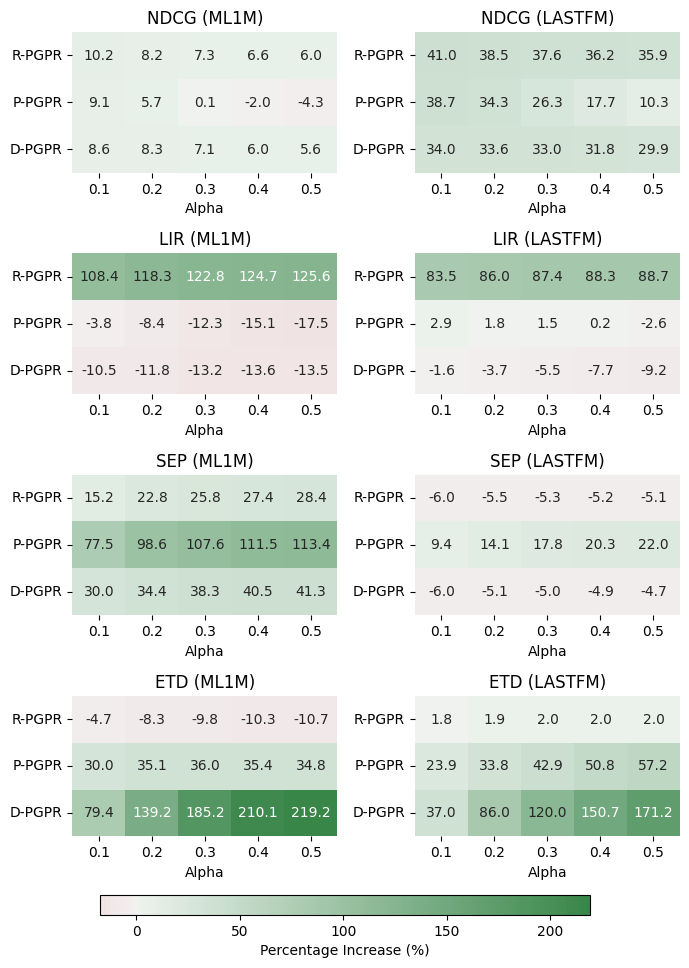

In [136]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 10))

min_val = min(merged_df_lastfm['percentage_change'].min(), merged_df_ml1m['percentage_change'].min())
max_val = max(merged_df_lastfm['percentage_change'].max(), merged_df_ml1m['percentage_change'].max())

custom_cmap = sns.diverging_palette(10, 133, as_cmap=True)

for i, metric in enumerate(metrics):
    # Plot for LASTFM
    metric_data_lastfm = merged_df_lastfm[merged_df_lastfm['metric'] == metric]
    heatmap_data_lastfm = metric_data_lastfm.pivot(
        index='opt_opt',
        columns='alpha',
        values='percentage_change'
    )
    heatmap_data_lastfm = heatmap_data_lastfm.iloc[::-1]
    sns.heatmap(
        heatmap_data_lastfm,
        annot=True,
        fmt=".1f",
        cmap=custom_cmap,
        center=0,
        vmin=min_val,
        vmax=max_val,
        ax=axes[i, 1],
        cbar=False
    )
    axes[i, 1].set_title(f"{metric.upper()} (LASTFM)")
    axes[i, 1].set_xlabel("Alpha")
    axes[i, 1].set_ylabel("")
    axes[i, 1].set_yticklabels(axes[i, 1].get_yticklabels(), rotation=0)

    # Plot for ML1M
    metric_data_ml1m = merged_df_ml1m[merged_df_ml1m['metric'] == metric]
    heatmap_data_ml1m = metric_data_ml1m.pivot(
        index='opt_opt',
        columns='alpha',
        values='percentage_change'
    )
    heatmap_data_ml1m = heatmap_data_ml1m.iloc[::-1]
    sns.heatmap(
        heatmap_data_ml1m,
        annot=True,
        fmt=".1f",
        cmap=custom_cmap,
        center=0,
        vmin=min_val,
        vmax=max_val,
        ax=axes[i, 0],
        cbar=False
    )
    axes[i, 0].set_title(f"{metric.upper()} (ML1M)")
    axes[i, 0].set_xlabel("Alpha")
    axes[i, 0].set_ylabel("")
    axes[i, 0].set_yticklabels(axes[i, 0].get_yticklabels(), rotation=0)

# Colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
fig.colorbar(axes[0, 1].collections[0], cbar_ax, orientation='horizontal', label='Percentage Increase (%)')

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Table 3: Recommendation utility (NDCG).

In [137]:
# Average NDCG
def get_average_ndcg(
    dataset,
    LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt,
    group='Overall',
    metric='ndcg',
    alpha_values=[0.1],
    ):

    combined_df = pd.concat([LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt])

    filtered_df = combined_df[
    (combined_df['alpha'].isin(alpha_values)) & 
    (combined_df['group'] == group) & 
    (combined_df['metric'] == metric)
    ]

    grouped_df = filtered_df.groupby(['opt'])['data'].mean().reset_index()

    # Rename data for the name of the dataset
    grouped_df = grouped_df.rename(columns={'data': f'{dataset}'})
    grouped_df = grouped_df.rename(columns={'opt': 'Model'})
    
    # Rename Model values
    rename_dict = {
        'LIRopt': 'R-PGPR',
        'SEPopt': 'P-PGPR',
        'ETDopt': 'D-PGPR',
        'ETD_SEP_opt': 'DP-PGPR',
        'SEP_LIR_opt': 'PR-PGPR',
        'ETD_LIR_opt': 'DR-PGPR',
        'ETD_SEP_LIR_opt': 'DPR-PGPR'
    }
    grouped_df['Model'] = grouped_df['Model'].replace(rename_dict)

    # Reorder the DataFrame
    order = ['R-PGPR', 'P-PGPR', 'D-PGPR', 'DP-PGPR', 'PR-PGPR', 'DR-PGPR', 'DPR-PGPR']
    grouped_df = grouped_df.set_index('Model').loc[order].reset_index()
    

    return grouped_df

In [138]:
ndcg_lastfm = get_average_ndcg("LASTFM", LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt)
ndcg_m1lm = get_average_ndcg("M1LM",LIRopt_ml1m, SEPopt_ml1m, ETDopt_ml1m, ETD_SEP_opt_ml1m, SEP_LIR_opt_ml1m, ETD_LIR_opt_ml1m, ETD_SEP_LIR_opt_ml1m)

# Merge the two dataframes by model
ndcg_combined = pd.merge(ndcg_m1lm, ndcg_lastfm, on='Model')
ndcg_combined

,Model,M1LM,LASTFM
0,R-PGPR,0.322131,0.121233
1,P-PGPR,0.318890,0.119234
2,D-PGPR,0.317457,0.115204
3,DP-PGPR,0.310853,0.112290
4,PR-PGPR,0.321971,0.120343
5,DR-PGPR,0.315207,0.114369
6,DPR-PGPR,0.314363,0.113171


### Table 4: Explanation quality (EQ, LIR, EP, ETD).

In [139]:
# Average NDCG
def get_explanation_quality(
    dataset,
    baseline, LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt,
    group='Overall',
    metrics=['LIR', 'SEP', 'ETD'],
    alpha_values=[0.1],
    ):

    combined_df = pd.concat([baseline, LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt])

    filtered_df = combined_df[
    (combined_df['alpha'].isin(alpha_values)) & 
    (combined_df['group'] == group) & 
    (combined_df['metric'].isin(metrics))
    ]

    grouped_df = filtered_df.groupby(['opt', 'metric'])['data'].mean().reset_index()

    grouped_df = grouped_df.pivot(index='opt', columns='metric', values='data').reset_index()
    grouped_df['EQ'] = grouped_df['LIR'] + grouped_df['SEP'] + grouped_df['ETD']

    grouped_df = grouped_df[['opt', 'EQ', 'LIR', 'SEP', 'ETD']]

    # Rename data for the name of the dataset
    grouped_df = grouped_df.rename(columns={'data': f'{dataset}'})
    grouped_df = grouped_df.rename(columns={'opt': 'Model'})
    
    # Rename Model values
    rename_dict = {
        'baseline': 'PGPR',
        'LIRopt': 'R-PGPR',
        'SEPopt': 'P-PGPR',
        'ETDopt': 'D-PGPR',
        'ETD_SEP_opt': 'DP-PGPR',
        'SEP_LIR_opt': 'PR-PGPR',
        'ETD_LIR_opt': 'DR-PGPR',
        'ETD_SEP_LIR_opt': 'DPR-PGPR'
    }
    grouped_df['Model'] = grouped_df['Model'].replace(rename_dict)

    # Reorder the DataFrame
    order = ['PGPR' ,'R-PGPR', 'P-PGPR', 'D-PGPR', 'DP-PGPR', 'PR-PGPR', 'DR-PGPR', 'DPR-PGPR']
    grouped_df = grouped_df.set_index('Model').loc[order].reset_index()
    

    return grouped_df

In [140]:
exp_quality_ml1m = get_explanation_quality("ML1M", baseline_ml1m, LIRopt_ml1m, SEPopt_ml1m, ETDopt_ml1m, ETD_SEP_opt_ml1m, SEP_LIR_opt_ml1m, ETD_LIR_opt_ml1m, ETD_SEP_LIR_opt_ml1m)
exp_quality_ml1m

metric,Model,EQ,LIR,SEP,ETD
0,PGPR,0.775346,0.163167,0.459663,0.152517
1,R-PGPR,1.014880,0.340059,0.529424,0.145397
2,P-PGPR,1.171121,0.156897,0.815995,0.198228
3,D-PGPR,1.017195,0.146056,0.597496,0.273642
4,DP-PGPR,1.237174,0.153429,0.795782,0.287964
5,PR-PGPR,1.256217,0.334700,0.744746,0.176772
6,DR-PGPR,1.196408,0.330208,0.582408,0.283791
7,DPR-PGPR,1.312922,0.325221,0.740118,0.247583


In [141]:
exp_quality_lastfm = get_explanation_quality("LASTFM", baseline, LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt)
exp_quality_lastfm

metric,Model,EQ,LIR,SEP,ETD
0,PGPR,1.004958,0.084775,0.789873,0.130310
1,R-PGPR,1.030475,0.155598,0.742230,0.132647
2,P-PGPR,1.113027,0.087198,0.864391,0.161438
3,D-PGPR,1.004156,0.083440,0.742242,0.178474
4,DP-PGPR,1.116022,0.084650,0.849809,0.181563
5,PR-PGPR,1.149251,0.154560,0.843748,0.150943
6,DR-PGPR,1.080297,0.153703,0.745882,0.180713
7,DPR-PGPR,1.138516,0.152578,0.830031,0.155906


### Table 5: The difference between male and female user groups in terms of average recommendation utility (NDCG) and explanation quality (LIR, SEP and ETD).

In [142]:
exp_quality_ml1m_male = get_explanation_quality("ML1M", baseline_ml1m, LIRopt_ml1m, SEPopt_ml1m, ETDopt_ml1m, ETD_SEP_opt_ml1m, SEP_LIR_opt_ml1m, ETD_LIR_opt_ml1m, ETD_SEP_LIR_opt_ml1m, group="Male")
exp_quality_ml1m_female = get_explanation_quality("ML1M", baseline_ml1m, LIRopt_ml1m, SEPopt_ml1m, ETDopt_ml1m, ETD_SEP_opt_ml1m, SEP_LIR_opt_ml1m, ETD_LIR_opt_ml1m, ETD_SEP_LIR_opt_ml1m, group="Female")
#exp_quality_ml1m_diff = exp_quality_ml1m_male - exp_quality_ml1m_female


In [148]:


def get_metric_gender_delta(
    dataset_name,
    LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt, baseline,
    group='Overall',
    metrics=['ndcg', 'LIR', 'SEP', 'ETD'],
    alpha_values=[0.1, 0.2, 0.3, 0.4, 0.5],
    ):

    combined_df = pd.concat([LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt, baseline])
    filtered_df = combined_df[
    (combined_df['alpha'].isin(alpha_values)) & 
    (combined_df['metric'].isin(metrics)) &
    (combined_df['group'].isin(['Male', 'Female']))
    ]

    #group algorithm, metric and group and obtain the mean  
    grouped_df = filtered_df.groupby(['opt', 'metric', 'group'])['data'].mean().unstack()

    grouped_df['Difference'] = grouped_df['Female'] - grouped_df['Male']

    #need to do this
    grouped_df = grouped_df[['Difference']].reset_index()
    
    # set metrics as columns
    grouped_df = grouped_df.pivot(index='opt', columns='metric', values='Difference').reset_index()
    
 
    grouped_df = grouped_df.rename(columns={'opt': 'Model'})

    #model value renaming
    rename_dict = {
        'LIRopt': 'R-PGPR',
        'SEPopt': 'P-PGPR',
        'ETDopt': 'D-PGPR',
        'ETD_SEP_opt': 'DP-PGPR',
        'SEP_LIR_opt': 'PR-PGPR',
        'ETD_LIR_opt': 'DR-PGPR',
        'ETD_SEP_LIR_opt': 'DPR-PGPR',
        'baseline': 'PGPR'
    }
    grouped_df['Model'] = grouped_df['Model'].replace(rename_dict)
    
    order = ['PGPR','R-PGPR', 'P-PGPR', 'D-PGPR', 'DP-PGPR', 'PR-PGPR', 'DR-PGPR', 'DPR-PGPR']
    grouped_df = grouped_df.set_index('Model').loc[order].reset_index()


    # add dataset names and delta sign to columns
    grouped_df = grouped_df.rename(columns={'ndcg': f'ΔNDCG {dataset_name}', 
                                          'LIR': f'ΔLIR {dataset_name}',
                                          'SEP': f'ΔSEP {dataset_name}',
                                          'ETD': f'ΔETD {dataset_name}'})
    return grouped_df

In [149]:
use_high_topk = False
if(use_high_topk):
    ml1m_df = get_metric_gender_delta(dataset_name = 'ML1M',
                                    LIRopt = LIRopt_ml1m,
                                    SEPopt = SEPopt_ml1m,
                                    ETDopt = ETDopt_ml1m,
                                    ETD_SEP_opt = ETD_SEP_opt_ml1m,
                                    SEP_LIR_opt = SEP_LIR_opt_ml1m,
                                    ETD_LIR_opt = ETD_LIR_opt_ml1m,
                                    ETD_SEP_LIR_opt = ETD_SEP_LIR_opt_ml1m,
                                    baseline = baseline_ml1m)

    lastfm_df = get_metric_gender_delta(dataset_name = 'LASTFM',
                                    LIRopt = LIRopt,
                                    SEPopt = SEPopt,
                                    ETDopt = ETDopt,
                                    ETD_SEP_opt = ETD_SEP_opt,
                                    SEP_LIR_opt = SEP_LIR_opt,
                                    ETD_LIR_opt = ETD_LIR_opt,
                                    ETD_SEP_LIR_opt = ETD_SEP_LIR_opt,
                                    baseline=baseline)

else:
    print("using topk=10")

    ml1m_df = get_metric_gender_delta(dataset_name = 'ML1M',
                                    LIRopt = LIRopt_ml1m_topk10,
                                    SEPopt = SEPopt_ml1m_topk10,
                                    ETDopt = ETDopt_ml1m_topk10,
                                    ETD_SEP_opt = ETD_SEP_opt_ml1m_topk10,
                                    SEP_LIR_opt = SEP_LIR_opt_ml1m_topk10,
                                    ETD_LIR_opt = ETD_LIR_opt_ml1m_topk10,
                                    ETD_SEP_LIR_opt = ETD_SEP_LIR_opt_ml1m_topk10,
                                    baseline = baseline_ml1m_topk10)

    lastfm_df = get_metric_gender_delta(dataset_name = 'LASTFM',
                                    LIRopt = LIRopt_topk10,
                                    SEPopt = SEPopt_topk10,
                                    ETDopt = ETDopt_topk10,
                                    ETD_SEP_opt = ETD_SEP_opt_topk10,
                                    SEP_LIR_opt = SEP_LIR_opt_topk10,
                                    ETD_LIR_opt = ETD_LIR_opt_topk10,
                                    ETD_SEP_LIR_opt = ETD_SEP_LIR_opt_topk10,
                                    baseline=baseline_topk10)

#merge to display prettily
merged_df = pd.merge(lastfm_df, ml1m_df, on='Model', how='outer')

#Reorder the columns since i screwed up the order before
order =  ['Model',
         'ΔNDCG ML1M', 'ΔLIR ML1M', 'ΔSEP ML1M', 'ΔETD ML1M','ΔNDCG LASTFM', 'ΔLIR LASTFM', 'ΔSEP LASTFM', 'ΔETD LASTFM']
merged_df = merged_df[order]


from tabulate import tabulate

formatted_table = tabulate(merged_df, headers='keys', tablefmt='pipe', showindex=False)
print(formatted_table)

using topk=10
| Model    |   ΔNDCG ML1M |   ΔLIR ML1M |    ΔSEP ML1M |   ΔETD ML1M |   ΔNDCG LASTFM |   ΔLIR LASTFM |   ΔSEP LASTFM |   ΔETD LASTFM |
|:---------|-------------:|------------:|-------------:|------------:|---------------:|--------------:|--------------:|--------------:|
| PGPR     |  0.000791497 |  -0.0188839 |  0.00167111  | 0.000167398 |    0.0009223   |  -0.00297435  |  -0.000557664 |  -0.00147062  |
| R-PGPR   |  0.00543664  |  -0.0262502 | -0.00101022  | 0.00100076  |   -0.00372363  |  -0.00602655  |  -0.00177716  |  -0.00205418  |
| P-PGPR   |  0.00521852  |  -0.0109691 | -0.000927277 | 0.000153874 |   -0.00442611  |  -0.00819628  |   0.000816552 |  -0.0027926   |
| D-PGPR   |  0.00389741  |  -0.0225218 | -0.00335762  | 0.00167909  |    0.00252701  |  -0.000843328 |  -0.00263538  |   0.000643068 |
| DP-PGPR  |  0.00298194  |  -0.0172497 | -0.00132105  | 0.000969093 |    0.0028415   |  -0.00872038  |  -0.00113629  |   0.000586921 |
| PR-PGPR  |  0.00902474  |  -0.02

## Statistical significance between genders

In [113]:
def get_gendered_data(
    LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt, baseline,
    metrics=['ndcg', 'LIR', 'SEP', 'ETD'],
    alpha_values=[0.1, 0.2, 0.3, 0.4, 0.5],
    ):

    combined_df = pd.concat([LIRopt, SEPopt, ETDopt, ETD_SEP_opt, SEP_LIR_opt, ETD_LIR_opt, ETD_SEP_LIR_opt, baseline])
    filtered_df = combined_df[
    (combined_df['alpha'].isin(alpha_values)) & 
    (combined_df['metric'].isin(metrics)) &
    (combined_df['group'].isin(['Male', 'Female']))
    ]

    
    filtered_df = filtered_df.sort_values(by=['metric', 'alpha'])
    filtered_df['opt'] = filtered_df['opt'].str.replace('LIRopt', 'R-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('SEPopt', 'P-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('ETDopt', 'D-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('ETD_SEP_LIR_opt', 'DPR-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('ETD_SEP_opt', 'DP-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('ETD_LIR_opt', 'DR-PGPR')
    filtered_df['opt'] = filtered_df['opt'].str.replace('SEP_LIR_opt', 'PR-PGPR')

    
    female_df = filtered_df[(filtered_df['group'] == 'Female')]
    male_df = filtered_df[(filtered_df['group'] == 'Male')]
    
    return female_df, male_df

def get_pvalue(df_female, df_male, metric, opt):
    opt_female_df = df_female[(df_female['metric'] == metric)]
    opt_female_df = opt_female_df[(opt_female_df['opt'] == opt)]
    opt_female_df = opt_female_df.loc[:, ['data']]
    opt_male_df = df_male[(df_male['metric'] == metric)]
    opt_male_df = opt_male_df[(opt_male_df['opt'] == opt)]
    opt_male_df = opt_male_df.loc[:, ['data']]
    (statistic, pvalue) = stats.kruskal(opt_female_df['data'], opt_male_df['data'])
    return pvalue

(ml1m_df_f, ml1m_df_m) = get_gendered_data(LIRopt = LIRopt_ml1m,
                                 SEPopt = SEPopt_ml1m,
                                 ETDopt = ETDopt_ml1m,
                                 ETD_SEP_opt = ETD_SEP_opt_ml1m,
                                 SEP_LIR_opt = SEP_LIR_opt_ml1m,
                                 ETD_LIR_opt = ETD_LIR_opt_ml1m,
                                 ETD_SEP_LIR_opt = ETD_SEP_LIR_opt_ml1m,
                                 baseline = baseline_ml1m)

(lastfm_df_f, lastfm_df_m) = get_gendered_data(LIRopt = LIRopt,
                                 SEPopt = SEPopt,
                                 ETDopt = ETDopt,
                                 ETD_SEP_opt = ETD_SEP_opt,
                                 SEP_LIR_opt = SEP_LIR_opt,
                                 ETD_LIR_opt = ETD_LIR_opt,
                                 ETD_SEP_LIR_opt = ETD_SEP_LIR_opt,
                                 baseline=baseline)

indexes = ['R-PGPR', 'P-PGPR', 'D-PGPR', 'DP-PGPR', 'PR-PGPR', 'DR-PGPR', 'DPR-PGPR']


def create_pvalue_df(df_f, df_m, metrics, indexes):
    pvalues_df = pd.DataFrame(columns=metrics, index=indexes)
    for metric in metrics:
        results = []
        for index in indexes:
            results.append(get_pvalue(df_f, df_m, metric, index))
        pvalues_df[metric] = results
    return pvalues_df

In [ ]:
print('LastFM:')
pvalue_df_lastfm = create_pvalue_df(lastfm_df_f, lastfm_df_m, metrics, indexes)
print(pvalue_df_lastfm)
print(pvalue_df_lastfm.applymap(lambda x: x<0.05))

LastFM:
              ndcg       LIR       SEP       ETD
R-PGPR    0.754023  0.009023  0.250592  0.008816
P-PGPR    0.601508  0.009023  0.916815  0.601508
D-PGPR    0.009023  0.047202  0.916815  0.916815
DP-PGPR   0.916815  0.117185  0.754023  0.754023
PR-PGPR   0.754023  0.009023  0.601508  0.916815
DR-PGPR   0.117185  0.009023  0.250592  0.916815
DPR-PGPR  0.916815  0.009023  0.916815  0.754023
           ndcg    LIR    SEP    ETD
R-PGPR    False   True  False   True
P-PGPR    False   True  False  False
D-PGPR     True   True  False  False
DP-PGPR   False  False  False  False
PR-PGPR   False   True  False  False
DR-PGPR   False   True  False  False
DPR-PGPR  False   True  False  False


In [ ]:
print('MovieLens:')
pvalue_df_ml1m = create_pvalue_df(ml1m_df_f, ml1m_df_m, metrics, indexes)
print(pvalue_df_ml1m)
print(pvalue_df_ml1m.applymap(lambda x: x<0.05))

MovieLens
              ndcg       LIR       SEP       ETD
R-PGPR    0.250592  0.009023  0.347208  0.347208
P-PGPR    0.916815  0.117185  0.601508  0.250592
D-PGPR    0.250592  0.009023  0.464702  0.916815
DP-PGPR   0.347208  0.028280  0.754023  0.754023
PR-PGPR   0.916815  0.016294  0.601508  0.754023
DR-PGPR   0.754023  0.009023  0.601508  0.916815
DPR-PGPR  0.601508  0.009023  0.601508  0.916815
           ndcg    LIR    SEP    ETD
R-PGPR    False   True  False  False
P-PGPR    False  False  False  False
D-PGPR    False   True  False  False
DP-PGPR   False   True  False  False
PR-PGPR   False   True  False  False
DR-PGPR   False   True  False  False
DPR-PGPR  False   True  False  False


While we tried to compute our best guess of what they could have meant with "statistical significance testing" for table 5 (as in the distribution of values for male and female and different alpha for fixed metric and optimisation priority), we decided to not include this in our report as the differences (probably due to different preprocessing) are too severe.

In [160]:
def get_difference_avg(df_f, df_m):
    df_diff = df_f.drop(columns=['group'])
    df_diff = df_diff.sort_values(by=['opt','metric'])
    df_m = df_m.sort_values(by=['opt','metric'])
    df_diff['data'] = df_diff['data'].values - df_m['data'].values
    return df_diff.groupby(['opt', 'metric'])['data'].mean().unstack()

In [161]:
print('LastFM:')
print(get_difference_avg(lastfm_df_f, lastfm_df_m))

LastFM:
metric         ETD       LIR       SEP      ndcg
opt                                             
D-PGPR   -0.000518 -0.004115  0.000153  0.005838
DP-PGPR  -0.001269 -0.005801  0.000469 -0.000581
DPR-PGPR -0.000936 -0.012304 -0.000353 -0.000645
DR-PGPR  -0.000820 -0.012580 -0.002251  0.003734
P-PGPR   -0.001132 -0.007479 -0.000484 -0.002534
PR-PGPR  -0.000382 -0.012518 -0.000957 -0.003093
R-PGPR   -0.001400 -0.012808 -0.002032 -0.000703
baseline -0.001471 -0.002974 -0.000558  0.000922


In [162]:
print('MovieLens:')
print(get_difference_avg(ml1m_df_f, ml1m_df_m))

MovieLens:
metric         ETD       LIR       SEP      ndcg
opt                                             
D-PGPR    0.000335 -0.016335  0.003755  0.005089
DP-PGPR   0.002593 -0.017050  0.000800  0.006629
DPR-PGPR -0.000143 -0.028008  0.001906  0.007367
DR-PGPR  -0.000683 -0.027897 -0.002666  0.001099
P-PGPR   -0.000919 -0.010209 -0.000540  0.000340
PR-PGPR   0.000456 -0.027717  0.002253 -0.002199
R-PGPR   -0.000817 -0.028189 -0.007524 -0.002680
baseline -0.000151 -0.006645  0.000699  0.005592
